## Wikigap 2022 report ([source code](https://github.com/wmcz/voila-notebooks/blob/master/wikigap-2022-report.ipynb))

### License statement
Copyright 2022 Martin Urbanec (martin.urbanec@wikimedia.cz)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
from IPython.display import display, Markdown, Latex, HTML

import os
import requests
from datetime import datetime

import wmpaws
import pandas as pd
pd.set_option('display.max_rows', None)

In [2]:
!curl -s 'https://cs.wikipedia.org/w/index.php?title=Wikipedista:Martin_Urbanec/tmp&oldid=21174972&action=raw' | grep -o 'user=[-a-zA-Z0-9 ()]*' | cut -d= -f 2 > ~/data/wmcz-wikigap-2022-users.txt

In [3]:
users = open(os.path.expanduser('~/data/wmcz-wikigap-2022-users.txt')).read().split('\n')
users.pop()
usersDf = pd.DataFrame({
    'user_name': users
})
usersDf.set_index('user_name', inplace=True)

## Účastníci Wikigapu podle data registrace

V této sekci reportu jsou zobrazeni účastníci Wikigapu podle jejich zkušeností na Wikipedii. Za nováčka jsou považováni uživatelé, kteří svůj účet vytvořili po 1. březnu 2022.

In [4]:
tenureDf = wmpaws.run_sql('''
SELECT
    user_name,
    IF(user_registration > '20220301000000', 'Newcomer', 'Experienced') AS user_role
FROM user
WHERE
        user_name IN ({users})
    AND user_registration IS NOT NULL
'''.format(
    users=', '.join(["'%s'" % x for x in users])
), 'cswiki')
tenureAggDf = tenureDf.groupby('user_role').count().rename(columns={'user_name': 'count'})

/srv/paws/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


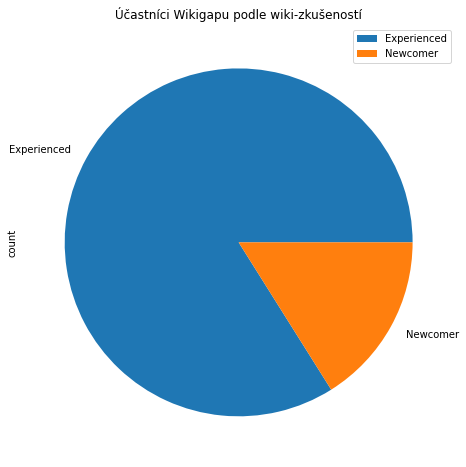

In [5]:
tenureAggDf.plot.pie(y='count', figsize=(8,8), title='Účastníci Wikigapu podle wiki-zkušeností');

In [6]:
tenureAggDf

,count
user_role,
Experienced,47
Newcomer,9


## Účastníci Wikigapu podle pohlaví

Pohlaví je použito podle informace uložené v [uživatelských nastaveních na české Wikipedii](https://cs.wikipedia.org/wiki/Special:Preferences). Výrazná většina uživatelů tento parametr nemá vyplněný – toto je třeba při vnímání reportu mít na paměti.

In [7]:
gendersDf = wmpaws.run_sql('''
SELECT user_name, up_value AS gender
FROM user_properties
JOIN user ON up_user=user_id
WHERE
    up_property='gender'
    AND user_name IN ({users})
'''.format(
    users=', '.join(["'%s'" % x for x in users])
), 'cswiki')
gendersDf.set_index('user_name', inplace=True)
gendersDf = usersDf.join(gendersDf).reset_index().fillna('unknown')
gendersAggDf = gendersDf.reset_index(drop=True).groupby('gender').count().rename(columns={'user_name': 'count'})

/srv/paws/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


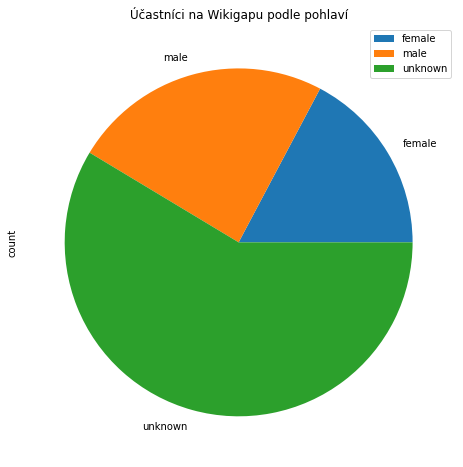

In [8]:
gendersAggDf.plot.pie(y='count', title='Účastníci na Wikigapu podle pohlaví', figsize=(8,8));